<a href="https://colab.research.google.com/github/kundajelab/adar_editing/blob/master/xgboost_with_shap/ALLSUBSTRATES_XGBOOST_WITH_TREESHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

## Uncomment these lines if running as a google colab notebook: 
#! git clone https://github.com/kundajelab/adar_editing
#import os
#os.chdir("adar_editing/xgboost_with_shap/")
#!pip install shap
#!pip install --upgrade xgboost
#!pip install cufflinks
#!pip install numpy==1.15

In [2]:
%load_ext autoreload
%autoreload 2   

In [3]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))


In [4]:
#helper utilities for model training and interpretation 
import shap
from helpers import * 

#set a random seed so code is reproducible 
random.seed(1234)

# load JS visualization code to notebook
shap.initjs()
import warnings
warnings.filterwarnings('ignore')

#visualization utilities 
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
import plotly.plotly as py
import numpy as np
from plotly.offline import iplot
from plotly.graph_objs import Heatmap


/users/annashch/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/users/annashch/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)



## Train AJUBA & TTYH2, Predict NEIL1 <a name='outline'>


In [5]:
data_neil_comp=pd.read_csv("../xin_feature_matrices/neil1_computational.features.csv",header=0,sep=',',index_col=0)
#remove any null editing level values 
data_neil_comp=data_neil_comp[~data_neil_comp["editing_value"].isnull().values]
## prepare data for training with xgboost 
data_neil_comp=format_for_xgboost(data_neil_comp)
test_split=data_neil_comp

(428, 219)


In [6]:
data_ajuba_comp=pd.read_csv("../xin_feature_matrices/ajuba_bc_computational.features.csv",header=0,sep=',',index_col=0)
#remove any null editing level values 
data_ajuba_comp=data_ajuba_comp[~data_ajuba_comp["editing_value"].isnull().values]
## prepare data for training with xgboost 
data_ajuba_comp=format_for_xgboost(data_ajuba_comp)
train_split1,eval_split1=split_train_eval_by_mut_pos(data_ajuba_comp[~data_ajuba_comp['mut_pos'].isna()])
null_mut_pos=data_ajuba_comp[data_ajuba_comp['mut_pos'].isna()]
train_split1=pd.concat((train_split1,null_mut_pos),axis=0)

(482, 186)
{64.0: 22, 65.0: 21, 66.0: 22, 67.0: 22, 68.0: 22, 69.0: 23, 70.0: 23, 71.0: 24, 72.0: 23, 73.0: 33, 75.0: 33, 76.0: 24, 77.0: 24, 78.0: 23, 79.0: 23, 80.0: 22, 81.0: 22, 82.0: 22, 83.0: 44}


In [7]:
data_ttyh2_comp=pd.read_csv("../xin_feature_matrices/ttyh2_computational.features.csv",header=0,sep=',',index_col=0)
#remove any null editing level values 
data_ttyh2_comp=data_ttyh2_comp[~data_ttyh2_comp["editing_value"].isnull().values]
## prepare data for training with xgboost 
data_ttyh2_comp=format_for_xgboost(data_ttyh2_comp)
train_split2,eval_split2=split_train_eval_by_mut_pos(data_ttyh2_comp[~data_ttyh2_comp['mut_pos'].isna()])
null_mut_pos=data_ttyh2_comp[data_ttyh2_comp['mut_pos'].isna()]
train_split2=pd.concat((train_split2,null_mut_pos),axis=0)

(601, 216)
{21.0: 18, 22.0: 18, 23.0: 18, 24.0: 20, 25.0: 17, 26.0: 20, 27.0: 20, 28.0: 20, 29.0: 18, 30.0: 18, 31.0: 17, 32.0: 17, 33.0: 17, 34.0: 18, 35.0: 18, 36.0: 18, 79.0: 17, 80.0: 17, 81.0: 18, 82.0: 18, 83.0: 19, 84.0: 19, 85.0: 20, 86.0: 29, 88.0: 27, 89.0: 18, 90.0: 17, 91.0: 17, 92.0: 17, 93.0: 14, 94.0: 36}


In [8]:
#concatenate train/eval splits from Neil1 & TTYH2 
train_split=pd.concat((train_split1,train_split2),axis=0)
eval_split=pd.concat((eval_split1,eval_split2),axis=0)

In [9]:
train_split.reset_index(inplace=True, drop=True) 
eval_split.reset_index(inplace=True,drop=True)
test_split.reset_index(inplace=True,drop=True)

In [10]:
#Remove any non-varying features 
train_novar=get_singleval_features(train_split)
eval_novar=get_singleval_features(eval_split)
test_novar=get_singleval_features(test_split)
uniform_features_to_drop=list(set(train_novar+eval_novar+test_novar))

In [11]:
#Remove any null features 
train_null=get_all_null_features(train_split)
eval_null=get_all_null_features(eval_split)
test_null=get_all_null_features(test_split)
null_features_to_drop=list(set(train_null+eval_null+test_null))

In [12]:
to_drop=list(set(uniform_features_to_drop+null_features_to_drop))
print("\n".join(to_drop))

u2_length_internal_ecs
u2_exist
u1_exist
u1_length_internal_es
site_next_nt:A
d2_exist
d3_5prm_cp_bulge
d2_5prm_cp_hairpin
d1_length_bulge
mut_ref_nt:A
site_next_nt:U
mut_type:wt
mut_type:mismatch
u2_5prm_cp_internal
u3_3prm_cp_internal
mut_exist
u3_length_internal_ecs
site_5prm_cp_hairpin
u1_3prm_cp_internal
d3_3prm_cp_bulge
site_prev_nt:A
u3_exist
site_length_hairpin
d1_exist
d3_exist
d1_5prm_cp_hairpin
u2_3prm_cp_internal
site_prev_nt:U
d3_length_bulge
d2_3prm_cp_bulge
d2_5prm_cp_bulge
u1_5prm_cp_hairpin
mut_same_as_site
u2_length_internal_es
u1_length_hairpin
d1_length_hairpin
u1_length_internal_ecs
d1_3prm_cp_bulge
d1_5prm_cp_bulge:C:G
d2_length_hairpin
d3_5prm_cp_hairpin
mut_type:indel
d3_length_hairpin
u3_5prm_cp_internal
d1_5prm_cp_bulge
u3_length_internal_es
u1_5prm_cp_internal


In [13]:
#remove teh features that don't change across isoforms , or are null for all isoforms
for cur_to_drop in to_drop: 
    try:
        train_split=train_split.drop(cur_to_drop,axis=1)
    except: 
        pass
    try:
        eval_split=eval_split.drop(cur_to_drop,axis=1)
    except: 
        pass 
    try:
        test_split=test_split.drop(to_drop,axis=1)
    except: 
        pass

In [14]:

train_y=train_split['editing_value']
train_X=train_split.drop(['editing_value'],axis=1)
eval_y=eval_split['editing_value']
eval_X=eval_split.drop(['editing_value'],axis=1)
test_y=test_split['editing_value']
test_X=test_split.drop(['editing_value'],axis=1)

In [15]:
print(train_X.shape)
print(train_y.shape)
print(eval_X.shape)
print(eval_y.shape)
print(test_X.shape)
print(test_y.shape)


(863, 189)
(863,)
(180, 189)
(180,)
(428, 218)
(428,)


In [16]:
train_cols=set(train_X.columns)
eval_cols=set(eval_X.columns)
test_cols=set(test_X.columns)


In [17]:
common=train_cols.intersection(eval_cols)
common=common.intersection(test_cols)
common=list(common)
#print(common)
train_X=train_X[common]
eval_X=eval_X[common]
test_X=test_X[common]
print(train_X.shape)
print(train_y.shape)
print(eval_X.shape)
print(eval_y.shape)
print(test_X.shape)
print(test_y.shape)


(863, 143)
(863,)
(180, 143)
(180,)
(428, 143)
(428,)


In [18]:
## format matrixes for xgboost 
import xgboost
dtrain=xgboost.DMatrix(train_X,train_y)
deval=xgboost.DMatrix(eval_X,eval_y)
dtest=xgboost.DMatrix(test_X,test_y)

In [19]:
## set model training parameters 
from __future__ import unicode_literals
param=dict() 
param['nthread'] = 20
#rmse -- root mean square error 
# mae -- mean absolute error 
# map -- mean average precision 
# auc -- area under ROC curve 
# aucpr -- area under precision recall curve 

#Note: the last metric in your 'eval_metric' list will get optimized 
param['eval_metric'] = ['aucpr','auc','mae','map','rmse']

In [20]:
evallist = [(deval, 'eval'), (dtrain, 'train')]


In [21]:
num_round = 1000
bst = xgboost.train(param, dtrain, num_round, evallist,early_stopping_rounds=10)

[0]	eval-aucpr:0.259376	eval-auc:0.791762	eval-mae:0.295392	eval-map:1	eval-rmse:0.306138	train-aucpr:0.294275	train-auc:0.781527	train-mae:0.27842	train-map:1	train-rmse:0.292277
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 10 rounds.
[1]	eval-aucpr:0.267345	eval-auc:0.804174	eval-mae:0.212587	eval-map:1	eval-rmse:0.221232	train-aucpr:0.309297	train-auc:0.798313	train-mae:0.196976	train-map:1	train-rmse:0.208408
[2]	eval-aucpr:0.26887	eval-auc:0.805392	eval-mae:0.153916	eval-map:1	eval-rmse:0.161591	train-aucpr:0.316726	train-auc:0.803558	train-mae:0.139942	train-map:1	train-rmse:0.14949
[3]	eval-aucpr:0.271125	eval-auc:0.808143	eval-mae:0.114712	eval-map:1	eval-rmse:0.122229	train-aucpr:0.322078	train-auc:0.806943	train-mae:0.100155	train-map:1	train-rmse:0.108529
[4]	eval-aucpr:0.271271	eval-auc:0.810963	eval-mae:0.086908	eval-map:1	eval-rmse:0.094132	train-aucpr:0.323777	train-auc:0.812027	trai

[45]	eval-aucpr:0.276755	eval-auc:0.816029	eval-mae:0.025795	eval-map:1	eval-rmse:0.038587	train-aucpr:0.33488	train-auc:0.827792	train-mae:0.005331	train-map:1	train-rmse:0.008002
[46]	eval-aucpr:0.276671	eval-auc:0.815898	eval-mae:0.02578	eval-map:1	eval-rmse:0.038575	train-aucpr:0.334895	train-auc:0.827823	train-mae:0.005203	train-map:1	train-rmse:0.007885
[47]	eval-aucpr:0.276852	eval-auc:0.815935	eval-mae:0.025735	eval-map:1	eval-rmse:0.038529	train-aucpr:0.334926	train-auc:0.827832	train-mae:0.005155	train-map:1	train-rmse:0.007775
[48]	eval-aucpr:0.276905	eval-auc:0.816031	eval-mae:0.025698	eval-map:1	eval-rmse:0.038527	train-aucpr:0.334959	train-auc:0.827884	train-mae:0.005009	train-map:1	train-rmse:0.007551
[49]	eval-aucpr:0.276662	eval-auc:0.815922	eval-mae:0.025713	eval-map:1	eval-rmse:0.038558	train-aucpr:0.335005	train-auc:0.827939	train-mae:0.004849	train-map:1	train-rmse:0.007304
[50]	eval-aucpr:0.27649	eval-auc:0.815928	eval-mae:0.02569	eval-map:1	eval-rmse:0.038537	tra

[91]	eval-aucpr:0.276356	eval-auc:0.816176	eval-mae:0.024828	eval-map:1	eval-rmse:0.038217	train-aucpr:0.335568	train-auc:0.82855	train-mae:0.001836	train-map:1	train-rmse:0.002716
[92]	eval-aucpr:0.275823	eval-auc:0.816117	eval-mae:0.024799	eval-map:1	eval-rmse:0.0382	train-aucpr:0.33557	train-auc:0.828554	train-mae:0.001814	train-map:1	train-rmse:0.002671
[93]	eval-aucpr:0.275782	eval-auc:0.816092	eval-mae:0.024789	eval-map:1	eval-rmse:0.038171	train-aucpr:0.335573	train-auc:0.828558	train-mae:0.001767	train-map:1	train-rmse:0.002612
[94]	eval-aucpr:0.275778	eval-auc:0.81607	eval-mae:0.024815	eval-map:1	eval-rmse:0.038186	train-aucpr:0.335561	train-auc:0.82856	train-mae:0.00174	train-map:1	train-rmse:0.002571
[95]	eval-aucpr:0.275778	eval-auc:0.816065	eval-mae:0.024824	eval-map:1	eval-rmse:0.038195	train-aucpr:0.335562	train-auc:0.828562	train-mae:0.001715	train-map:1	train-rmse:0.002547
[96]	eval-aucpr:0.276002	eval-auc:0.816062	eval-mae:0.024809	eval-map:1	eval-rmse:0.038206	train-

In [22]:
# save to binary file for faster loading
bst.save_model('cross.substrate.train.neil1.and.ttyh2.substrates.model')
# save model to text file 
bst.dump_model('cross.substrate.train.neil1.and.ttyh2.substrates.txt')


In [23]:
## get model predictions on the test, training, and eval splits 
test_pred = bst.predict(dtest)
train_pred=bst.predict(dtrain)
eval_pred=bst.predict(deval)

In [24]:
## Get performance metrics on full dataset 
from helpers import * 
print_aggregate_peformance_metrics(train_y,train_pred,
                                   eval_y,eval_pred,
                                   test_y,test_pred,
                                   positive_thresh=0.07)

Train
	Spearman corr : SpearmanrResult(correlation=0.9990272992237627, pvalue=0.0)
	Pearson corr : (0.9998825332780172, 0.0)
	MAE : 0.0012443876049598708
	MAPE : 0.027294476962433794
	RMSE : 0.001871197918719419
	auPRC : 0.9999761501799853
	auROC : 0.9999833505377776
Eval
	Spearman corr : SpearmanrResult(correlation=0.8505994672428673, pvalue=1.424378177345735e-51)
	Pearson corr : (0.9385441897257762, 3.7220302725515787e-84)
	MAE : 0.024711745814384064
	MAPE : 0.525057791157147
	RMSE : 0.03822062705942412
	auPRC : 0.9796906736090161
	auROC : 0.9879166666666668
Test
	Spearman corr : SpearmanrResult(correlation=0.5283019920484722, pvalue=3.877141130257992e-32)
	Pearson corr : (0.5934331231948061, 4.508003122648939e-42)
	MAE : 0.18169601858943424
	MAPE : 1.0236050481803016
	RMSE : 0.24462333254765117
	auPRC : 0.8598980470273552
	auROC : 0.7323332318001827


In [25]:
## Correlation values 
from scipy.stats import spearmanr,pearsonr
spearman_train=spearmanr(train_y,train_pred)
spearman_eval=spearmanr(eval_y,eval_pred)
spearman_test=spearmanr(test_y,test_pred)

pearson_train=pearsonr(train_y,train_pred)
pearson_eval=pearsonr(eval_y,eval_pred)
pearson_test=pearsonr(test_y,test_pred)

print("Spearman correlation:")
print("Train:"+str(spearman_train))
print("Eval:"+str(spearman_eval))
print("Test:"+str(spearman_test))
print("\n")
print("Pearson correlation:")
print("Train:"+str(pearson_train))
print("Eval:"+str(pearson_eval))
print("Test:"+str(pearson_test))

Spearman correlation:
Train:SpearmanrResult(correlation=0.9990272992237627, pvalue=0.0)
Eval:SpearmanrResult(correlation=0.8505994672428673, pvalue=1.424378177345735e-51)
Test:SpearmanrResult(correlation=0.5283019920484722, pvalue=3.877141130257992e-32)


Pearson correlation:
Train:(0.9998825332780172, 0.0)
Eval:(0.9385441897257762, 3.7220302725515787e-84)
Test:(0.5934331231948061, 4.508003122648939e-42)


In [26]:
## MAE
from sklearn.metrics import mean_absolute_error
mae_train=mean_absolute_error(train_y,train_pred)
print("MAE Train:"+str(mae_train))

mae_eval=mean_absolute_error(eval_y,eval_pred)
print("MAE Eval:"+str(mae_eval))

mae_test=mean_absolute_error(test_y,test_pred)
print("MAE Test:"+str(mae_test))


MAE Train:0.0012443876049598708
MAE Eval:0.024711745814384064
MAE Test:0.18169601858943424


In [27]:
## MAPE
pseudocount=0.01
mape_train=np.mean(np.abs((train_y - train_pred) /(pseudocount+train_y))) * 100
print("MAPE Train:"+str(mape_train)+"%")

mape_eval=np.mean(np.abs((eval_y - eval_pred) /(pseudocount+eval_y))) * 100
print("MAPE Eval:"+str(mape_eval)+"%")

mape_test=np.mean(np.abs((test_y - test_pred) /(pseudocount+test_y))) * 100
print("MAPE Test:"+str(mape_test)+"%")

MAPE Train:2.7294476962433794%
MAPE Eval:52.5057791157147%
MAPE Test:102.36050481803017%


In [28]:
## RMSE
from sklearn.metrics import mean_squared_error
import math 
rmse_train=math.sqrt(mean_squared_error(train_y,train_pred))
print("RMSE Train:"+str(rmse_train))

rmse_eval=math.sqrt(mean_squared_error(eval_y,eval_pred))
print("RMSE Eval:"+str(rmse_eval))

rmse_test=math.sqrt(mean_squared_error(test_y,test_pred))
print("RMSE Test:"+str(rmse_test))


RMSE Train:0.001871197918719419
RMSE Eval:0.03822062705942412
RMSE Test:0.24462333254765117


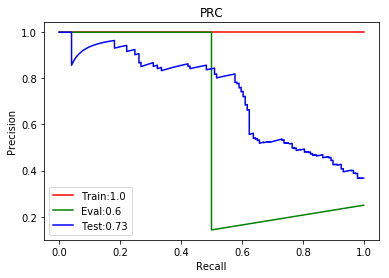

In [29]:
## PRC 
## PRC only valid for binary outcomes. 
## Editing levels < 0.5 are labeled as "0". 
## Editing levels >= 0.5 are labeled as "1". 

from sklearn.metrics import auc, precision_recall_curve

precision_train,recall_train,prc_thresholds_train=precision_recall_curve(train_y>=0.4,train_pred)
precision_eval,recall_eval,prc_thresholds_eval=precision_recall_curve(eval_y>=0.4,eval_pred)
precision_test,recall_test,prc_thresholds_test=precision_recall_curve(test_y>=0.4,test_pred)

auprc_train=auc(recall_train,precision_train)
auprc_eval=auc(recall_eval,precision_eval)
auprc_test=auc(recall_test,precision_test)

plt.plot(recall_train,precision_train,'r',label="Train:"+str(round(auprc_train,2)))
plt.plot(recall_eval,precision_eval,'g',label="Eval:"+str(round(auprc_eval,2)))
plt.plot(recall_test,precision_test,'b',label="Test:"+str(round(auprc_test,2)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PRC")
plt.legend()

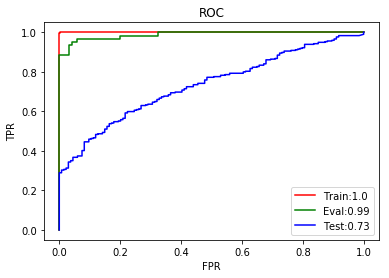

In [30]:
## ROC
from sklearn.metrics import roc_curve, roc_auc_score
fpr_train,tpr_train,roc_thresholds_train=roc_curve(train_y>=0.07,train_pred)
fpr_eval,tpr_eval,roc_thresholds_eval=roc_curve(eval_y>=0.07,eval_pred)
fpr_test,tpr_test,roc_thresholds_test=roc_curve(test_y>=0.07,test_pred)

auroc_train=roc_auc_score(train_y>=0.07,train_pred)
auroc_eval=roc_auc_score(eval_y>=0.07,eval_pred)
auroc_test=roc_auc_score(test_y>=0.07,test_pred)

plt.plot(fpr_train,tpr_train,'r',label="Train:"+str(round(auroc_train,2)))
plt.plot(fpr_eval,tpr_eval,'g',label="Eval:"+str(round(auroc_eval,2)))
plt.plot(fpr_test,tpr_test,'b',label="Test:"+str(round(auroc_test,2)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.legend()

In [31]:
#calculate R^2, which is representative of variance explained 
# https://datascienceplus.com/extreme-gradient-boosting-with-r/
# https://arxiv.org/pdf/1706.06060.pdf

residuals = test_y - test_pred

y_test_mean = np.mean(test_pred)
print(y_test_mean)
#calculate total sum of squares 
tss=sum((test_y-y_test_mean)*(test_y-y_test_mean))
print(tss)
# Calculate residual sum of squares
rss =  sum(residuals*residuals)
print(rss)
# Calculate R-squared
rsq  =  1 - (rss/tss)
print('The R-square of the test data is ', round(rsq,3), '\n')

0.122014195
32.6747235866851
25.6117660258356
The R-square of the test data is  0.216 



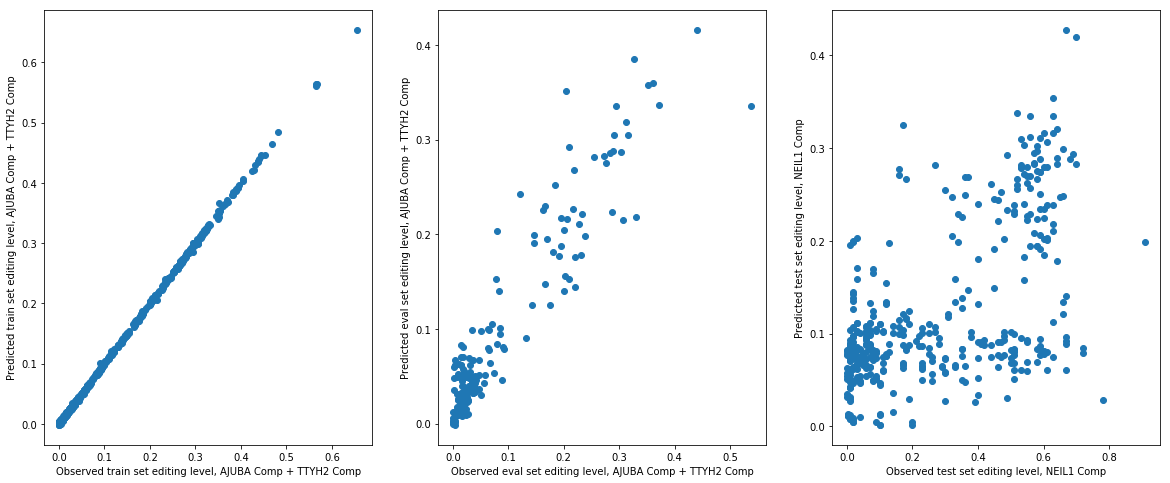

In [32]:
#plot the test set predictions 
matplotlib.rcParams['figure.figsize'] = [20, 8]
plt.subplot(1,3,1)
plt.plot(list(train_y),list(train_pred),'o')
plt.xlabel("Observed train set editing level, AJUBA Comp + TTYH2 Comp")
plt.ylabel("Predicted train set editing level, AJUBA Comp + TTYH2 Comp")
plt.subplot(1,3,2)
plt.plot(list(eval_y),list(eval_pred),'o')
plt.xlabel("Observed eval set editing level, AJUBA Comp + TTYH2 Comp")
plt.ylabel("Predicted eval set editing level, AJUBA Comp + TTYH2 Comp")
plt.subplot(1,3,3)
plt.plot(list(test_y),list(test_pred),'o')
plt.xlabel("Observed test set editing level, NEIL1 Comp")
plt.ylabel("Predicted test set editing level, NEIL1 Comp")

plt.show()

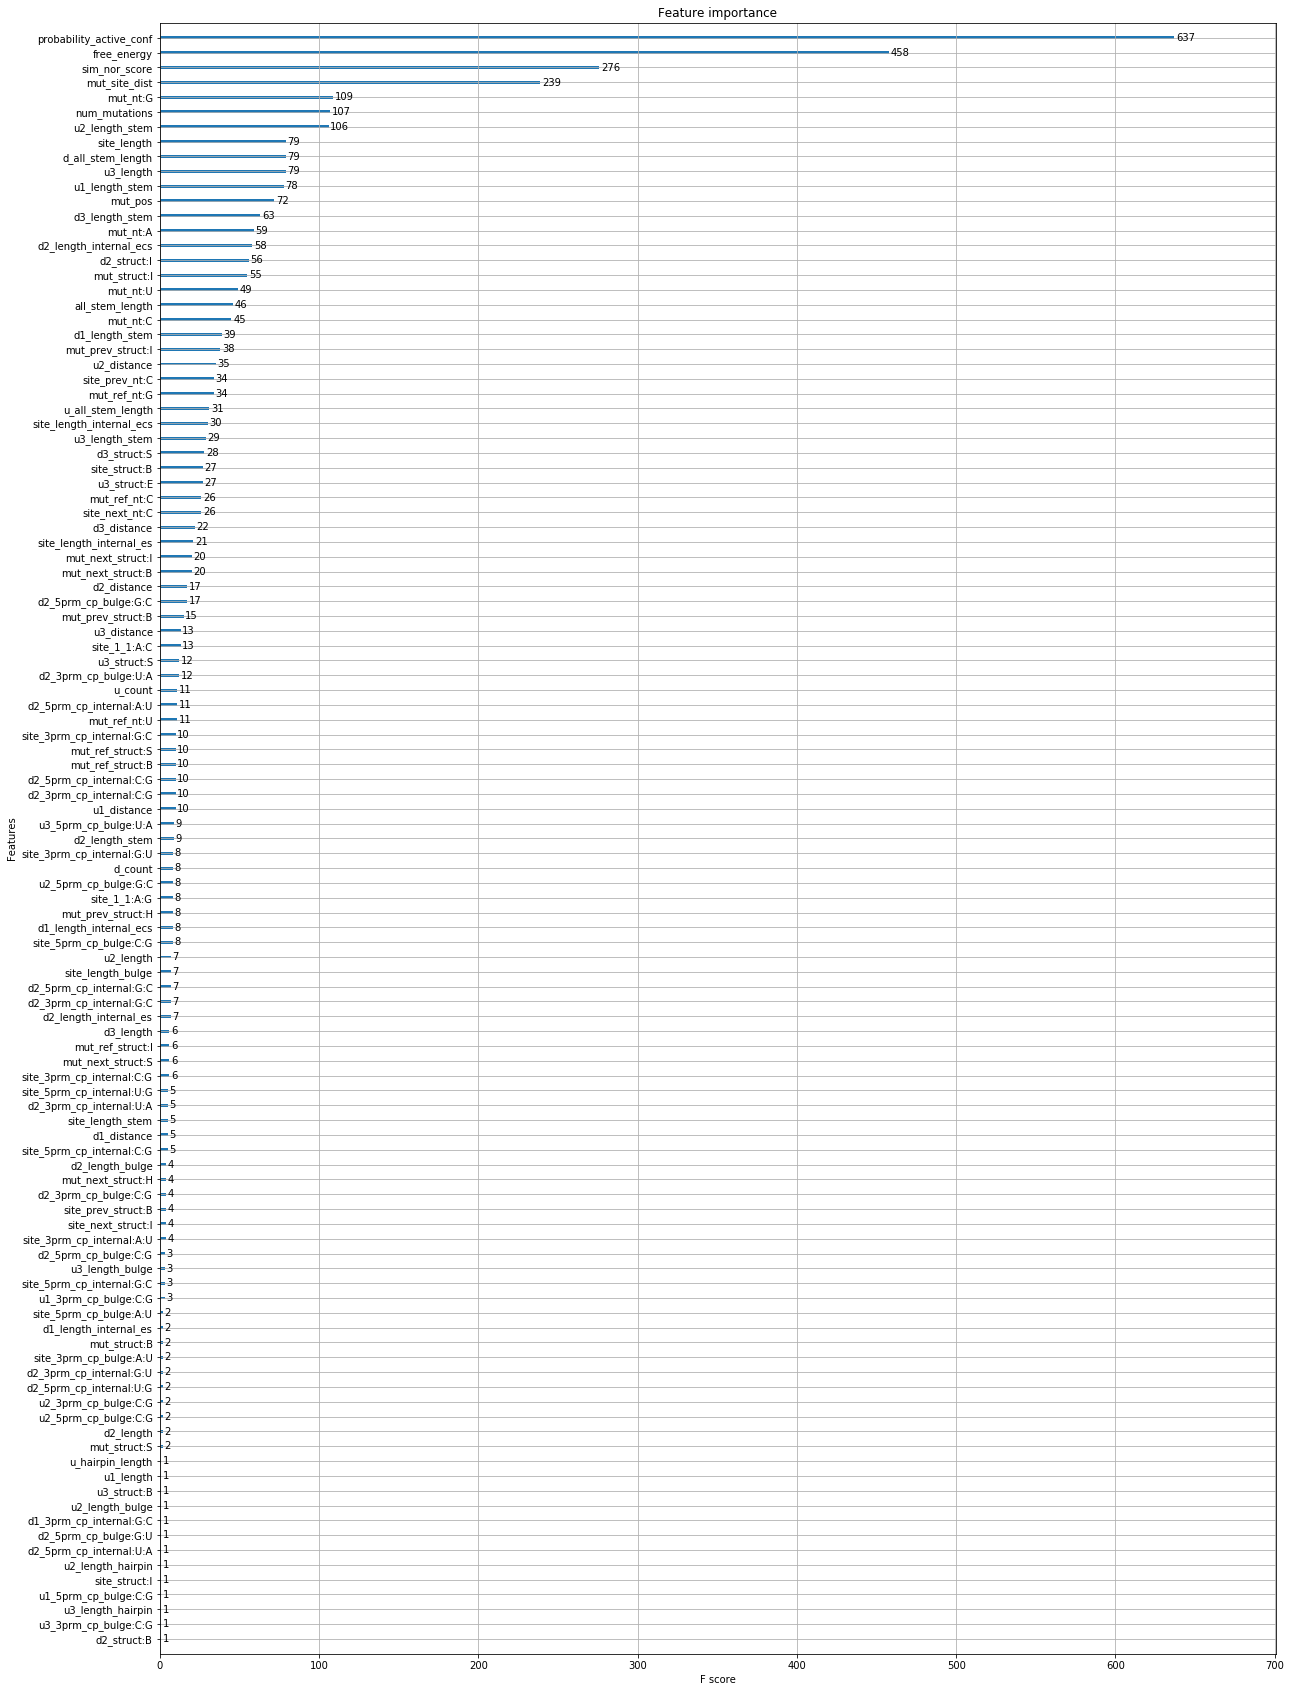

In [33]:
matplotlib.rcParams['figure.figsize'] = [20, 30]
xgboost.plot_importance(bst)

In [34]:
#xgboost.to_graphviz(bst, num_trees=2)


In [35]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(test_X)
shap_values.shape

(428, 143)

In [36]:
test_y=pd.DataFrame(test_y)
max_index=test_y.index[test_y['editing_value'] == max(test_y['editing_value'])]
max_row=test_y.index.get_loc(max_index[0])
# visualize prediction for isoform with the highest editing level 
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[max_row,:], test_X.iloc[max_row,:])

In [37]:
# visualize prediction for isoform with the lowest editing level 
shap.initjs()
min_index=test_y.index[test_y['editing_value'] == min(test_y['editing_value'])]
min_row=test_y.index.get_loc(min_index[0])
shap.force_plot(explainer.expected_value, shap_values[min_row,:], test_X.iloc[min_row,:])

In [38]:
# visualize the training set predictions
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values,train_X)

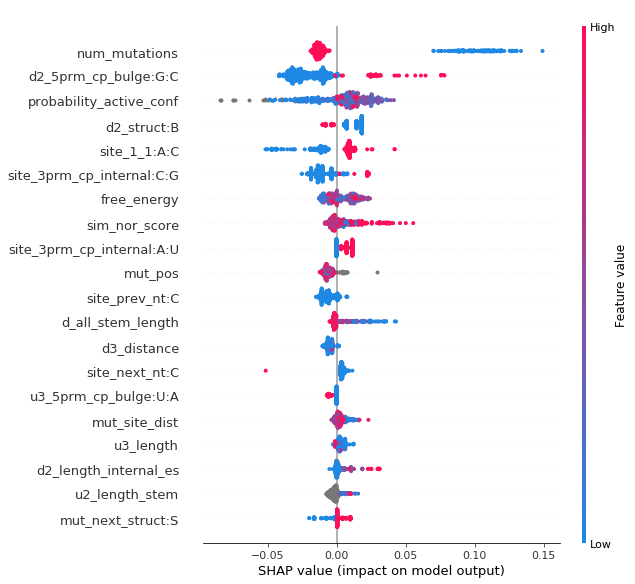

In [39]:
# summarize the effect of all the features 
shap.summary_plot(shap_values, test_X)


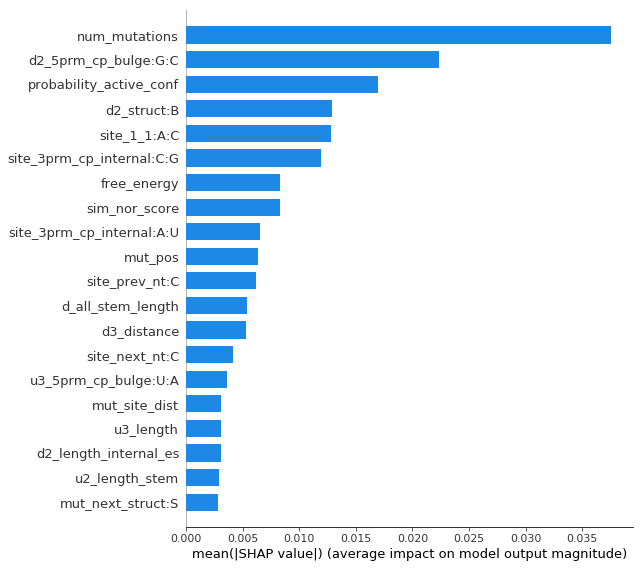

In [40]:
# We can also just take the mean absolute value of the SHAP values for each feature 
# to get a standard bar plot (produces stacked bars for multi-class outputs):
shap.summary_plot(shap_values, test_X, plot_type="bar")

In [41]:
## Compute pairwise interaction values from TreeShap
shap_interaction_values=explainer.shap_interaction_values(test_X)
shap_interaction_values.shape

(428, 143, 143)

In [42]:
##Average interaction values across the datapoints in the test set 
mean_interaction_values=np.mean(shap_interaction_values,axis=0)

In [43]:
Index=test_X.columns
Cols=test_X.columns
mean_interaction_values_df = pd.DataFrame(mean_interaction_values, index=Index, columns=Cols)

In [44]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
configure_plotly_browser_state()

trace = Heatmap(z=mean_interaction_values_df.values,
                   x=Cols,
                   y=Index)
iplot([trace],show_link=False)
